## Configuration

In [1]:
from collections import Counter

import pandas as pd

FANMOD_path = "C:\\Users\\User\\source\\repos\\fanmod-cmd\\out\\build\\x64-release"
FANMOD_exe = "LocalFANMOD.exe"

raw_data_folder = './../../data'
raw_data_folder_dataset = './TNBC_MIBITOF'
output_dir = './../../fanmod_output'
cache_dir = './../../parse_cache'
results_dir = './../../results/TNBC_MIBITOF'
motif_size = 3
iterations = 1000
force_run_fanmod = False
force_parse = False

In [2]:
cells_type = {
 0: 'B cells',
 1: 'CD3 T cells',
 2: 'CD4 t cells',
 3: 'CD8 T cells',
 4: 'DC',
 5: 'DC/Mono',
 6: 'Endothelial',
 7: 'Immune other',
 8: 'Macrophages',
 9: 'Mesenchyme',
 10: 'Mono/Neu',
 11: 'NK cells',
 12: 'Neutrophils',
 13: 'Tregs',
 14: 'Tumor',
 15: 'Unidentified'
}

Distant_metastases_class = {
    'POSITIVE': 'POSITIVE',
    'NEGATIVE': 'NEGATIVE',
}

survival_rate_cutoff = 1000

def map_survival_rate_to_class(survival_rate: int):
    if survival_rate<survival_rate_cutoff:
        return 'POSITIVE'
    else:
        return 'NEGATIVE'

class_to_color = {
    'POSITIVE': 'green',
    'NEGATIVE': 'orange',
}

## Steps
1. Initiate CISM object
2. Load datasets
3. Initiate CISMTask

In [3]:
from cism.cism import CISM

In [4]:
cism = CISM(fanmod_exe=FANMOD_exe,
            fanmod_path=FANMOD_path,
            network_dataset_root_path=raw_data_folder,
            fanmod_output_root_path=output_dir,
            fanmod_cache_root_path=cache_dir,
            motif_size=motif_size,
            iterations=iterations)

# adding Melanoma dataset
cism.add_dataset(raw_data_folder_dataset, 'Disease', 'TNBC', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=8, quantile_threshold=1)

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

In [5]:
import pandas as pd

survival_days_df = pd.read_csv(raw_data_folder + raw_data_folder_dataset + '/patient_class_survival_days.csv', names=['Patient', 'Survival Days'])

In [6]:
from cism.cism import TissueStateDiscriminativeMotifs
from cism.cism import DiscriminativeFeatureKey

discriminator = TissueStateDiscriminativeMotifs(cism=cism,
                                                tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class_survival_days.csv',
                                                tissue_state_to_string=None,
                                                common_cells_type=cells_type,
                                                tissue_state_func=map_survival_rate_to_class)

In [7]:
discriminator.get_patients_class(classes=None).groupby('patient_class').count()

,patient_class_id
patient_class,
NEGATIVE,30
POSITIVE,7


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


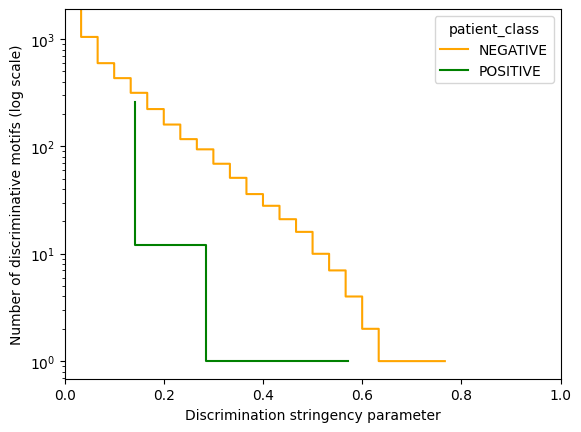

In [9]:
discover_result = discriminator.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=['NEGATIVE', 'POSITIVE'])

discover_result.plot_number_of_motifs_versus_discrimination_stringency_parameter(class_to_color=class_to_color)

In [11]:
discover_result.discriminative_motifs.head(10)

,Patient,FOV,ID,Freq,Count,Mean_Freq,STD,z_score,p_value,motif,nunique_colors,Disease,Patient_uId,colors_vec,colors_vec_hash,patient_class,patient_count,patient_percentage
3,10,FOV10,7722444,0.025521,1321,0.019233,0.000694,9.0653,0.000,gASVMAEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0]",-3729389300718233172,NEGATIVE,4,0.133333
10,10,FOV10,26596812,0.007419,384,0.003551,0.000309,12.5370,0.000,gASVMQEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0]",-4991885778241402576,NEGATIVE,4,0.133333
63,10,FOV10,5592396,0.000966,50,0.000581,0.000112,3.4252,0.000,gASVMAEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]",-774791192153669712,NEGATIVE,9,0.300000
94,10,FOV10,6048076,0.000657,34,0.000203,0.000072,6.2723,0.000,gASVLQEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",1304415446218764995,NEGATIVE,12,0.400000
111,10,FOV10,18199980,0.000502,26,0.000052,0.000055,8.1978,0.000,gASVMAEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0]",-1039844095083563261,NEGATIVE,6,0.200000
139,10,FOV10,13981004,0.000425,22,0.000145,0.000053,5.3096,0.000,gASVMAEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0]",977771267870568768,NEGATIVE,8,0.266667
150,10,FOV10,6113612,0.000406,21,0.000273,0.000078,1.6954,0.047,gASVMAEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]",-774791192153669712,NEGATIVE,4,0.133333
158,10,FOV10,6118732,0.000386,20,0.000000,0.000000,NaN,0.000,gASVTgEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,2,TNBC,TNBC10,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0]",-774791192153669712,NEGATIVE,8,0.266667
189,10,FOV10,18701740,0.000309,16,0.000000,0.000000,NaN,0.000,gASVTgEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,3,TNBC,TNBC10,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0]",-2188664753602309575,NEGATIVE,7,0.233333
207,10,FOV10,11058348,0.000270,14,0.000005,0.000010,27.4310,0.000,gASVKgEAAAAAAACMGG5ldHdvcmt4LmNsYXNzZXMuZGlncm...,1,TNBC,TNBC10,"[0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-3622911041628419534,NEGATIVE,15,0.500000


In [8]:
discriminator.cism.motifs_dataset.groupby('Patient')['ID'].count().describe()

count        37.000000
mean      69783.324324
std       56779.694467
min        3160.000000
25%       25705.000000
50%       45851.000000
75%      118933.000000
max      200457.000000
Name: ID, dtype: float64

In [9]:
# export data to excel
discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/number_of_motifs_{motif_size}_nodes_versus_shared_percentage.csv')

### Performance Diagram
1. Pairwise Learning
2. 3 Nodes Motifs
3. 4 Nodes Motifs
4. 5 Nodes Motifs
5. Permutation tests (for threshold 0.46)
6. GNN Performance

Here we export the data for 1, 4, 5


#### Pairwise Learning

In [9]:
#read graphs
from pairwise.reader import GraphReader

full_graph_df = pd.DataFrame()
full_graph_df = GraphReader.get_graphs(full_graph_df=full_graph_df,
                                       raw_data_folder=raw_data_folder,
                                       raw_data_folder_type=raw_data_folder_dataset,
                                       disease='TNBC',
                                       cells_type=cells_type)

In [10]:
from pairwise.pairwise_model import PairwiseAnalysis

pairwise_analysis = PairwiseAnalysis(
    tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class_survival_days.csv',
    tissue_state_to_string=None,
    tissue_state_func=map_survival_rate_to_class)

In [6]:
cell_type_counts = pairwise_analysis.get_cell_type_count_from_classes(
                            full_graph_df=full_graph_df,
                            classes=['NEGATIVE','POSITIVE'],
                            cells_type=cells_type,
                            normalize=True)
cell_type_counts.to_csv(results_dir +'/cell_type_frequency.csv')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='Frequency', ylabel='Cell Type'>

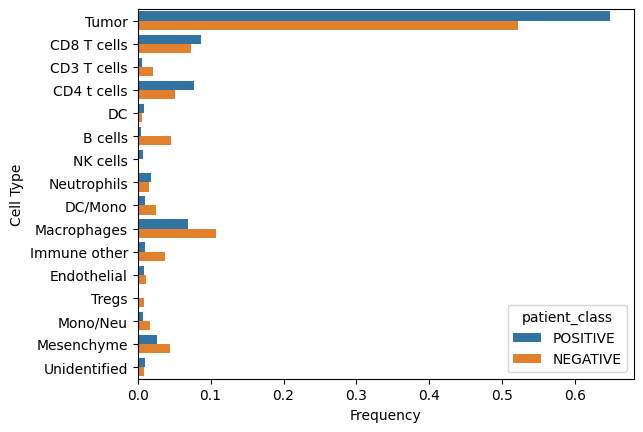

In [8]:
import seaborn as sns

sns.barplot(x='Frequency', y='Cell Type', hue='patient_class',
            data=cell_type_counts, orient='h')

In [11]:
group_a_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='NEGATIVE',
                                            cells_type=cells_type)
group_b_general_pairwise = pairwise_analysis.get_pairwise_counter(
                                            full_graph_df=full_graph_df,
                                            patient_class='POSITIVE',
                                            cells_type=cells_type)

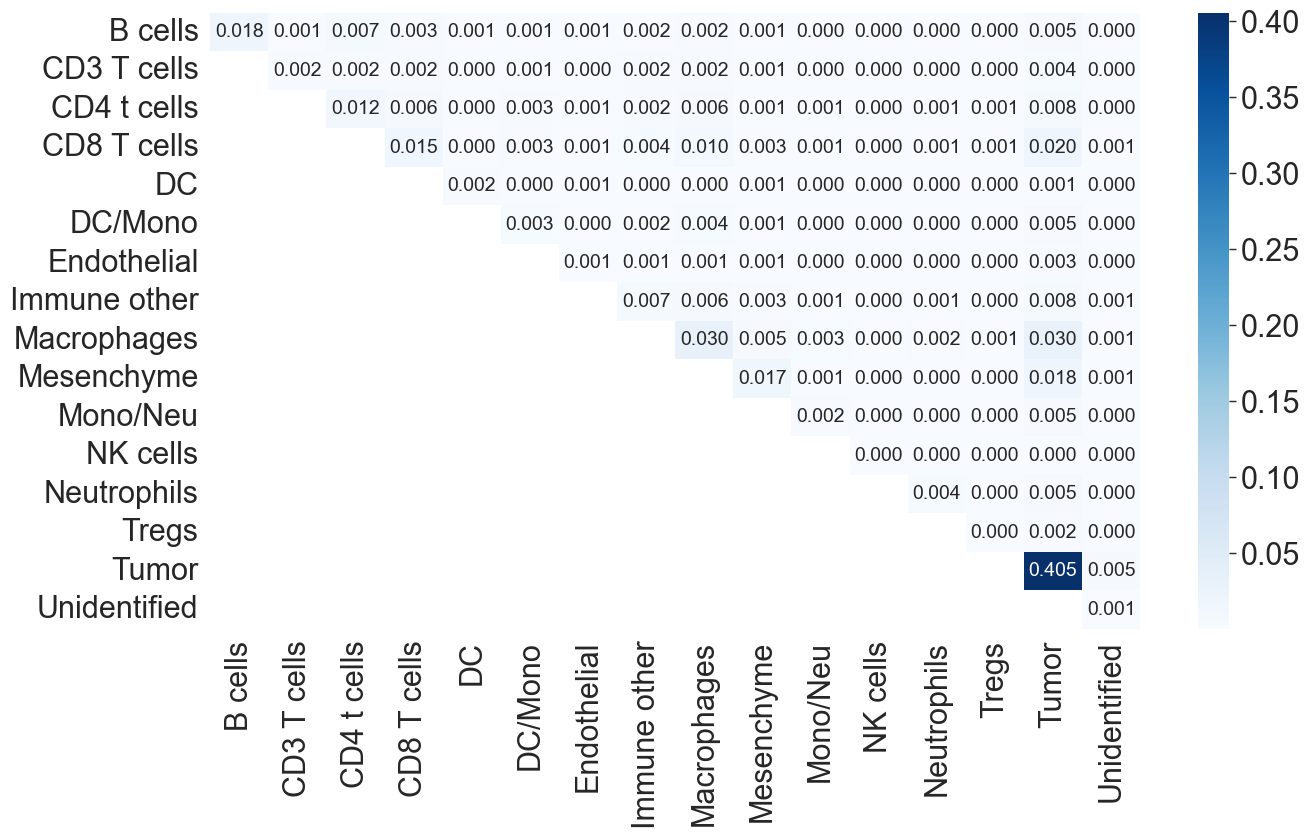

In [12]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

ax = sns.heatmap(group_a_general_pairwise, annot=True, mask=np.tril(np.ones_like(group_a_general_pairwise), k=-1), cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

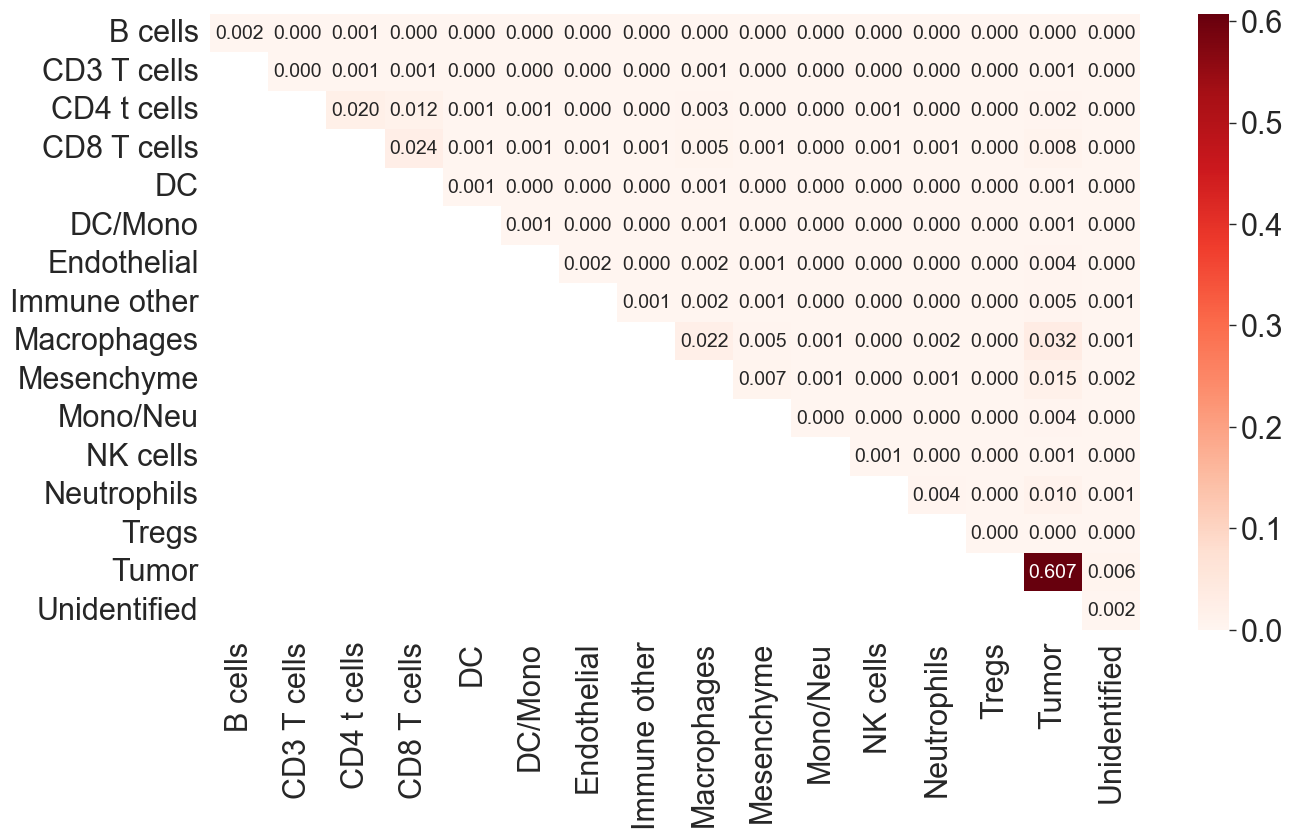

In [13]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

ax = sns.heatmap(group_b_general_pairwise, annot=True, mask=np.tril(np.ones_like(group_b_general_pairwise), k=-1), cmap='Reds', annot_kws={'size': 14}, fmt=".3f")

In [11]:
import numpy as np

roc_auc_scores = pairwise_analysis.analyze(full_graph_df=full_graph_df,
                                           cells_type=cells_type,
                                           labels=['NEGATIVE', 'POSITIVE'],
                                           trials=10)

print(f'roc_auc_score - mean: {np.mean(roc_auc_scores)} std: {np.std(roc_auc_scores)}')

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

roc_auc_score - mean: 0.5021428571428571 std: 0.027775623499229952


3 Nodes

In [16]:
local_motif_size = 3

cism_3_nodes = CISM(fanmod_exe=FANMOD_exe,
                    fanmod_path=FANMOD_path,
                    network_dataset_root_path=raw_data_folder,
                    fanmod_output_root_path=output_dir,
                    fanmod_cache_root_path=cache_dir,
                    motif_size=local_motif_size,
                    iterations=iterations)

# adding Melanoma dataset
cism_3_nodes.add_dataset(raw_data_folder_dataset, 'Disease', 'TNBC', force_run_fanmod=force_run_fanmod, force_parse=force_parse, n_jobs=1, quantile_threshold=1)

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [17]:
discriminator_3_nodes = TissueStateDiscriminativeMotifs(
                            cism=cism_3_nodes,
                            tissue_state_csv_path=raw_data_folder + raw_data_folder_dataset + '/patient_class_survival_days.csv',
                            tissue_state_to_string=None,
                            common_cells_type=cells_type,
                            tissue_state_func=map_survival_rate_to_class)

In [ ]:
discover_result = discriminator_3_nodes.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=['NEGATIVE', 'POSITIVE'])

discover_result.discriminative_motifs.drop(['Patient', 'FOV', 'Freq', 'Count', 'Mean_Freq', 'STD', 'z_score', 'p_value', 'Patient_uId'], axis=1).groupby('ID', observed=True).first().to_csv(results_dir +f'/number_of_motifs_{local_motif_size}_nodes_versus_shared_percentage.csv')

In [14]:
benchmark_results = None

In [22]:
for th in [0.2, 0.3, 0.4, 0.45, 0.5, 0.6, 0.7, 0.75, 0.8]:
    discriminator_benchmark = DiscriminatorBenchmark(
                                extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                shared_percentage=th,
                                trials=list(range(0, 1)))

    # run permutation test
    benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                    labels=['NEGATIVE', 'POSITIVE'],
                                                    rand_patient_class=False,
                                                    benchmark_results=benchmark_results)

benchmark_results.to_csv(results_dir+'/' + f'pipeline_benchmark_{local_motif_size}_nodes.csv')



extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.2,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6142857142857143
0.6644105970267494
12.945945945945946


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.3,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5761904761904761
1.8203883689514757
7.72972972972973


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.4,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8523809523809524
0.8109609470607433
7.8108108108108105


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8809523809523809
0.6015495506289252
6.162162162162162


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.5,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7999999999999999
0.5747437083869039
6.054054054054054


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.6,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7333333333333333
0.8629859470146342
2.7567567567567566


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.7,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7333333333333333
0.0
1.0


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.75,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7333333333333333
0.0
1.0


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.8,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


#### 3 Nodes AUC performance for patient classes permutation

In [34]:
benchmark_results = None

In [35]:
from cism.benchmark import DiscriminatorBenchmark
import numpy as np

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.45,
    trials=list(range(0, 100)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                labels=['NEGATIVE', 'POSITIVE'],
                                                max_class_features=30,
                                                rand_patient_class=True,
                                                benchmark_results=benchmark_results)

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.45,
    trials=list(range(0, 10)))

# run with real classes
benchmark_results = discriminator_benchmark.run(discriminator=discriminator_3_nodes,
                                                labels=['NEGATIVE', 'POSITIVE'],
                                                max_class_features=30,
                                                benchmark_results=benchmark_results)

benchmark_results



extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5547619047619048
2.142099108021986
1.4594594594594594


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6476190476190475
1.1987230443004493
2.2972972972972974


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6380952380952382
3.014728609442082
2.4594594594594597


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.40476190476190477
2.972092416687835
3.0


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6857142857142857
1.85915476936603
8.64864864864865


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.38095238095238093
0.96173017261856
1.2702702702702702


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.47619047619047616
0.5694947974514993
1.1891891891891893


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.4476190476190476
0.6414136040118043
1.2432432432432432


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6666666666666666
1.0932498320124249
4.837837837837838


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6190476190476191
3.2285327044066663
3.5135135135135136


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6333333333333333
1.5007505629691607
6.5675675675675675


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.4333333333333333
0.5355247770054966
1.135135135135135


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.3952380952380952
1.2769614836128107
1.3783783783783783


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6285714285714286
7.523835996890689
9.054054054054054


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5333333333333333
1.8470006527912792
11.756756756756756


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5666666666666667
1.5663503610155214
10.135135135135135


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7190476190476192
1.1455620071878747
4.513513513513513


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6380952380952382
1.7849891277501344
4.621621621621622


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7333333333333333
0.16439898730535726
2.027027027027027


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6047619047619048
1.0710495540109932
8.72972972972973


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.47619047619047616
1.7264068119885534
4.27027027027027


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.4714285714285714
2.2441114134632523
3.27027027027027


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5904761904761904
0.9251247785330667
4.243243243243243


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6571428571428571
1.4216261889192323
3.918918918918919


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6857142857142857
1.1695588347184027
2.5135135135135136


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7666666666666666
1.3863339864267632
5.45945945945946


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5714285714285714
0.534121039920059
1.2162162162162162


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5357142857142857
1.0815126766107135
2.324324324324324


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6285714285714286
0.8861632385092971
2.2162162162162162


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5285714285714286
0.22924343513512566
1.054054054054054


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6904761904761905
1.1203817453240015
1.5405405405405406


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7047619047619047
1.4992490612795952
11.594594594594595


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.719047619047619
1.9528988232404192
5.27027027027027


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7285714285714285
1.4866775743954068
10.108108108108109


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.7285714285714286
6.942708491734418
9.486486486486486


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6904761904761905
1.6051718215121324
7.081081081081081


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.3904761904761905
2.4220582912816875
5.54054054054054


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.3047619047619048
2.3788987282268153
1.7027027027027026


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5428571428571428
0.7123956116565481
3.2162162162162162


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.5595238095238095
0.8767945989619056
1.8108108108108107


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.4904761904761905
0.5534494613840601
1.162162162162162


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.4666666666666667
1.7124346505582142
6.108108108108108


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6095238095238095
1.0059880774701118
9.35135135135135


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6666666666666667
1.8013175024810992
8.243243243243244


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.4285714285714286
0.3736838766118223
1.162162162162162


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.419047619047619
1.520135129128595
1.4594594594594594


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.6428571428571428
1.5431725053866732
4.702702702702703


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: True,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

error probably due to zero discriminative features


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8619047619047618
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8476190476190476
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8476190476190476
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8428571428571427
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8809523809523809
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8428571428571427
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8523809523809524
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8476190476190476
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8523809523809524
1.244205790071742
12.702702702702704


extract_by: DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, use_motif:True, shared_percentage: 0.45,rand_patient_class: False,rand_motifs: False


  0%|          | 0/37 [00:00<?, ?it/s]

0.8809523809523809
1.244205790071742
12.702702702702704


,extract_by,use_motif,shared_percentage,cFeatures_sum,cFeatures_std,cFeatures_mean,random_state,rand_patient_class,rand_motifs,roc_auc_score,full_results_debug,error
0,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,54,2.142099,1.459459,0,True,False,0.554762,TP TN FN FP cFeatures \ TNBC1 ...,False
1,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,85,1.198723,2.297297,1,True,False,0.647619,TP TN FN FP cFeatures \ TNBC1 ...,False
2,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,91,3.014729,2.459459,2,True,False,0.638095,TP TN FN FP cFeatures \ TNBC1 ...,False
3,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,111,2.972092,3.000000,3,True,False,0.404762,TP TN FN FP cFeatures \ TNBC1 ...,False
4,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,320,1.859155,8.648649,4,True,False,0.685714,TP TN FN FP cFeatures \ TNBC1 ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
105,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,5,False,False,0.842857,TP TN FN FP cFeatures \ TNBC1 ...,False
106,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,6,False,False,0.852381,TP TN FN FP cFeatures \ TNBC1 ...,False
107,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,7,False,False,0.847619,TP TN FN FP cFeatures \ TNBC1 ...,False
108,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,8,False,False,0.852381,TP TN FN FP cFeatures \ TNBC1 ...,False


In [36]:
benchmark_results

,extract_by,use_motif,shared_percentage,cFeatures_sum,cFeatures_std,cFeatures_mean,random_state,rand_patient_class,rand_motifs,roc_auc_score,full_results_debug,error
0,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,54,2.142099,1.459459,0,True,False,0.554762,TP TN FN FP cFeatures \ TNBC1 ...,False
1,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,85,1.198723,2.297297,1,True,False,0.647619,TP TN FN FP cFeatures \ TNBC1 ...,False
2,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,91,3.014729,2.459459,2,True,False,0.638095,TP TN FN FP cFeatures \ TNBC1 ...,False
3,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,111,2.972092,3.000000,3,True,False,0.404762,TP TN FN FP cFeatures \ TNBC1 ...,False
4,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,320,1.859155,8.648649,4,True,False,0.685714,TP TN FN FP cFeatures \ TNBC1 ...,False
...,...,...,...,...,...,...,...,...,...,...,...,...
105,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,5,False,False,0.842857,TP TN FN FP cFeatures \ TNBC1 ...,False
106,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,6,False,False,0.852381,TP TN FN FP cFeatures \ TNBC1 ...,False
107,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,7,False,False,0.847619,TP TN FN FP cFeatures \ TNBC1 ...,False
108,DiscriminativeFeatureKey.STRUCTURE_AND_CELL_ID...,True,0.45,470,1.244206,12.702703,8,False,False,0.852381,TP TN FN FP cFeatures \ TNBC1 ...,False


In [38]:
benchmark_results.to_csv(results_dir +'/' + f'pipeline_{local_motif_size}_benchmark.csv')

#### Number of Discriminative Motifs Permutation tests

In [26]:
perm_result_dict = dict()

In [ ]:
from cism.cism import HardDiscriminativeFC

th = 0.45
feature_perm_conf = HardDiscriminativeFC(
                        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                        use_cells_type_composition=False,
                        use_motifs=True,
                        shared_percentage=th,
                        max_class_features=100000,
                        labels=['NN', 'NP'])

perm_result_dict[th] = [] if perm_result_dict.get(th) is None else perm_result_dict[th]
perm_result_dict[th].extend(discriminator.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=True,
    n_permutations=100,
    n_jobs=3))

perm_result_dict

In [22]:
original_motifs_count = discriminator.patient_class_permutation_test(
    feature_conf=feature_perm_conf,
    rand_patient_class=False,
    n_permutations=1,
    n_jobs=1)
original_motifs_count

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

[59]

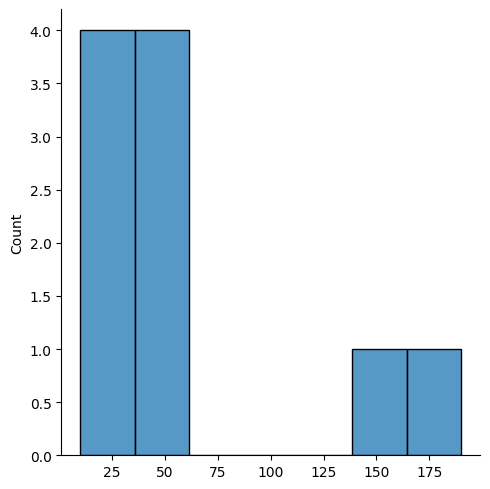

In [23]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [24]:
np.where(np.array(perm_result_dict[th])>original_motifs_count)

(array([1, 8], dtype=int64),)

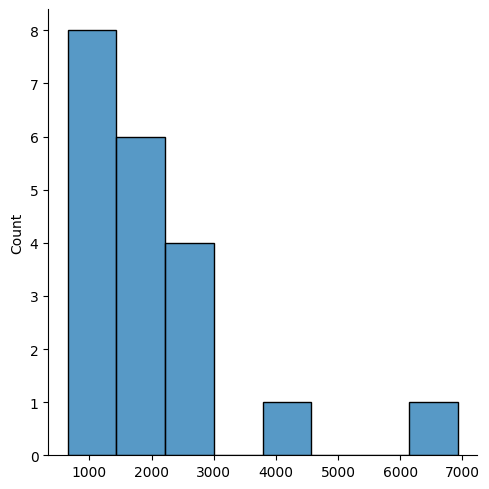

In [14]:
import seaborn as sns

sns.displot(perm_result_dict[th])

In [ ]:
2807

## Pipeline Permutation tests

In [6]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark
import numpy as np

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.46,
    trials=list(range(0, 30)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                rand_patient_class=True,
                                                benchmark_results=benchmark_results)

discriminator_benchmark = DiscriminatorBenchmark(
    extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
    shared_percentage=0.46,
    trials=list(range(0, 10)))

# run with real classes
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                benchmark_results=benchmark_results)

benchmark_results

In [8]:
benchmark_results.to_csv(results_dir +'/' + 'NN_NP_pipeline_benchmark.csv')

In [10]:
benchmark_results

## Pipeline randomize the motifs across the dataset

In [6]:
benchmark_results = None

In [ ]:
from cism.benchmark import DiscriminatorBenchmark

# run permutation test
discriminator_benchmark = DiscriminatorBenchmark(
                          extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                          shared_percentage=0.46,
                          trials=list(range(0, 100)))

# run permutation test
benchmark_results = discriminator_benchmark.run(discriminator=discriminator,
                                                labels=['NN', 'NP'],
                                                rand_patient_class=False,
                                                rand_motifs=True,
                                                benchmark_results=benchmark_results,
                                                n_jobs=1)

benchmark_results

In [ ]:
benchmark_results.to_csv(results_dir +'/' + 'NN_NP_motif_pipeline_benchmark.csv')

## 4 Nodes
## Within-motif spatial organization contributes to disease state prediction

In [8]:
shared_percentage_th = 0.54

In [12]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                   use_cells_type_composition=False,
                                   use_motifs=True,
                                   shared_percentage=shared_percentage_th,
                                   max_class_features=10,
                                   labels=['NN', 'NP'])

motif_space_features = discriminator_4_nodes.get_features(feature_conf=featureConf,
                                                          exclude_patients=[],
                                                          n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

FixedFormatter should only be used together with FixedLocator


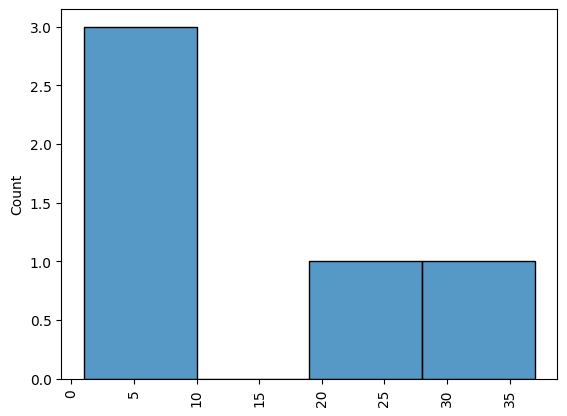

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

counter_across_patients = Counter()
for idx, row in motif_space_features.iterrows():
    counter_across_patients.update(row['features'])

g = sns.histplot(counter_across_patients)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [16]:
optimal_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                      exclude_patients=[],
                                                      n_jobs=1)

  0%|          | 0/38 [00:00<?, ?it/s]

In [17]:
optimal_result.get_roc_auc_score()

0.8611111111111112

In [19]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator_4_nodes.cism.motifs_dataset[discriminator_4_nodes.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 5, number of hashes: 5


{4071751116: -3224596876564360443,
 11561745772: 3341299229835211946,
 2454267148: -2785496978450312591,
 15341317580: 6191483428857422447,
 4880694732: 6501729852448164872}

In [40]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator_4_nodes.get_patients_class(['NN', 'NP'])
for motif_id in all_motif_features:
    patients_ids = discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID == motif_id) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == 'NN':
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

In [7]:
from cism import helpers
import networkx as nx
import numpy as np

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            target_motif = helpers.string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += 1

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

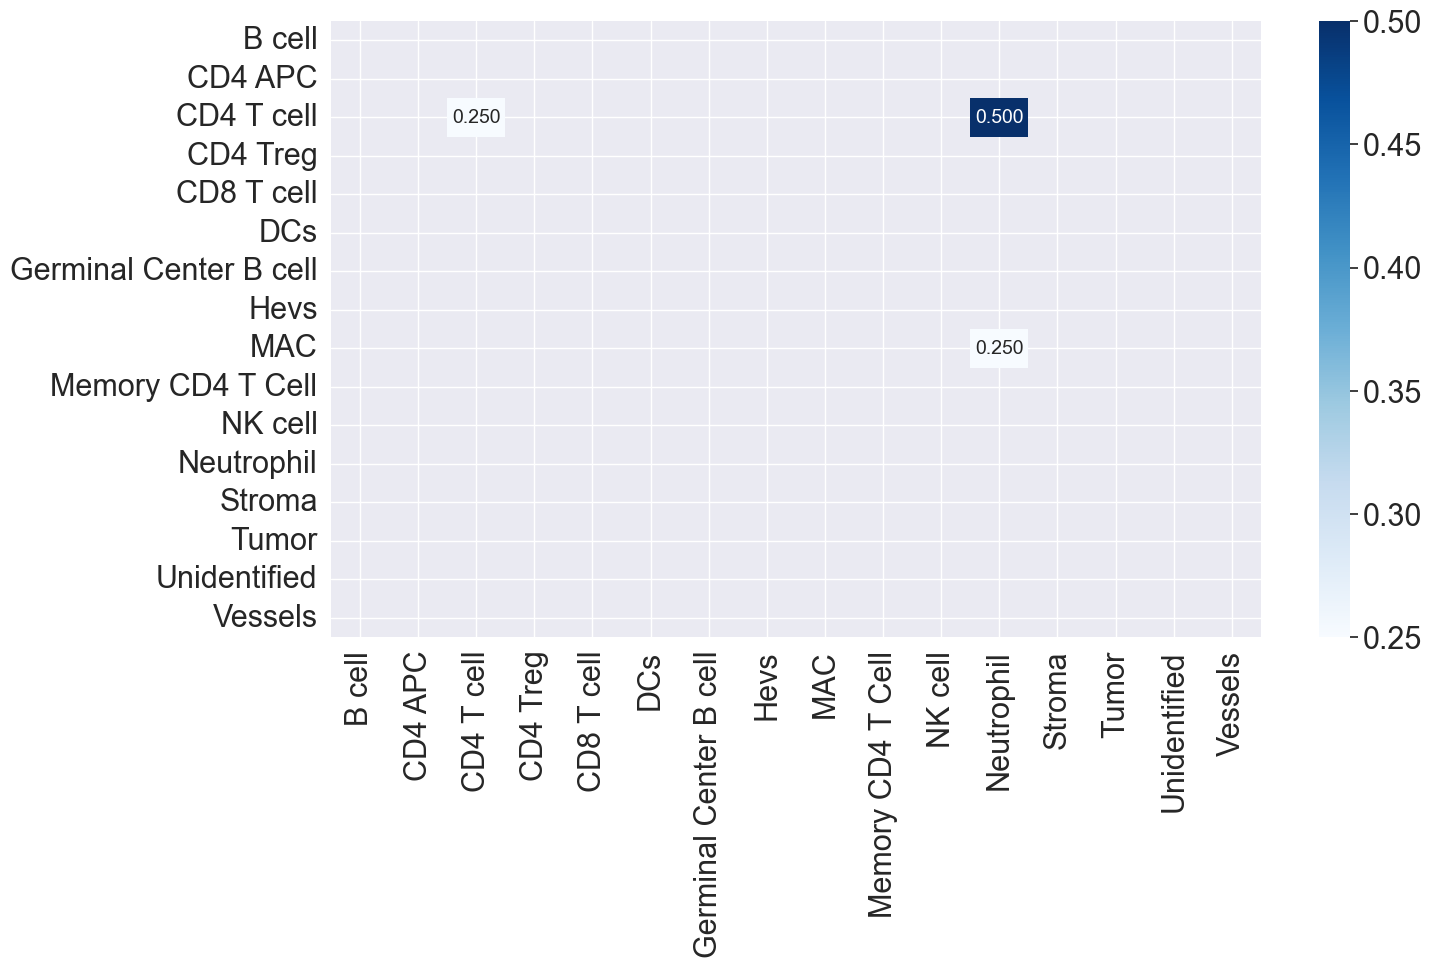

In [44]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(discriminator=discriminator_4_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_a_motifs)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

motif_id: 2454267148, hash_id: -2785496978450312591


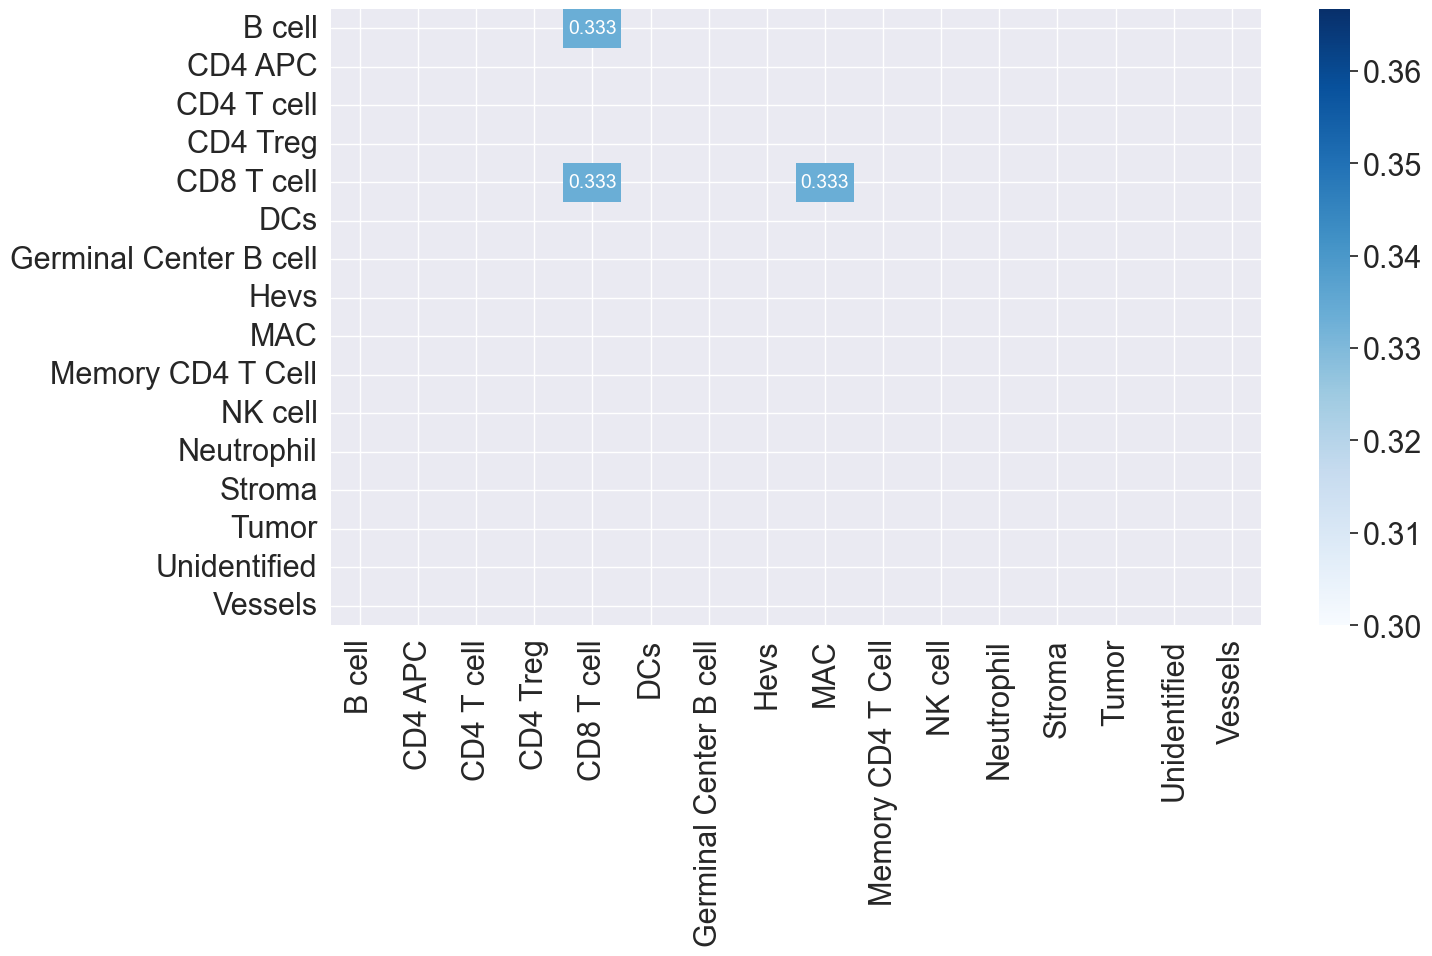

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)

df = create_weight_matrix_from_motifs(discriminator=discriminator_4_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_b_motifs[1:2])

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

In [57]:
from typing import Union

def switch_ci(motif_space_features: pd.DataFrame,
              target_motif_ids: list,
              motif_to_cells_identity_hash: dict) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id in motif_ids:
            if motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            ci_features.append(motif_to_cells_identity_hash[motif_id])

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

import numpy as np

switch_all_roc_auc_scores = []
for trial in range(10):
    motifs_patient_map, cell_type_composition_patient_map = \
        switch_ci(motif_space_features=motif_space_features,
                  target_motif_ids=[],
                  motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    featureConf = HardDiscriminativeFC(
        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
        use_cells_type_composition=False,
        use_motifs=True,
        shared_percentage=shared_percentage_th,
        max_class_features=10,
        labels=['NN', 'NP'],
        cell_type_composition_patient_map=cell_type_composition_patient_map,
        motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/38 [00:00<?, ?it/s]

0.45555555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

0.4541666666666666


  0%|          | 0/38 [00:00<?, ?it/s]

0.4583333333333333


  0%|          | 0/38 [00:00<?, ?it/s]

0.4736111111111111


  0%|          | 0/38 [00:00<?, ?it/s]

0.45555555555555555


  0%|          | 0/38 [00:00<?, ?it/s]

0.46249999999999997


  0%|          | 0/38 [00:00<?, ?it/s]

0.47500000000000003


  0%|          | 0/38 [00:00<?, ?it/s]

0.4763888888888889


  0%|          | 0/38 [00:00<?, ?it/s]

0.49444444444444446


  0%|          | 0/38 [00:00<?, ?it/s]

0.5055555555555555


0.47111111111111115

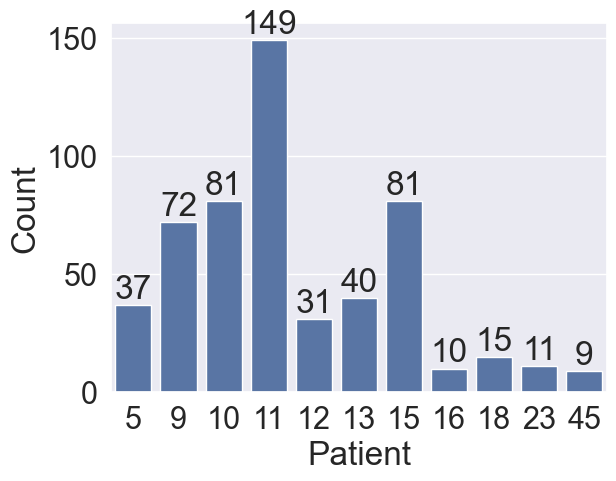

In [80]:
ax = sns.barplot(data=discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID.isin(group_b_motifs[1:2])) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby('Patient')['Count'].sum().reset_index(),
             x='Patient', y='Count')

for i in ax.containers:
    ax.bar_label(i,)

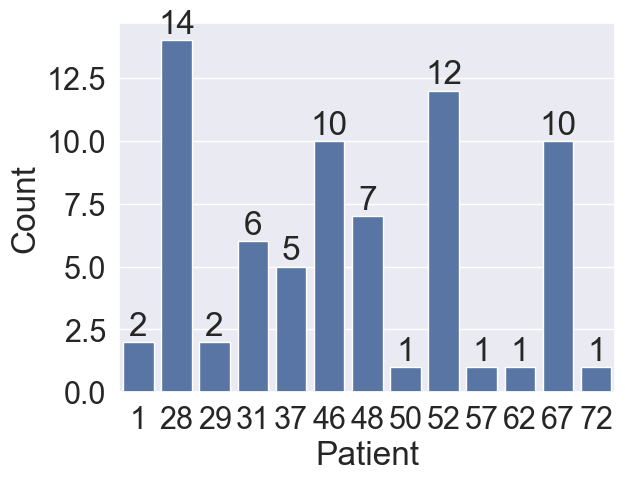

In [82]:
ax = sns.barplot(data=discriminator_4_nodes.cism.motifs_dataset[
        (discriminator_4_nodes.cism.motifs_dataset.ID.isin(group_a_motifs)) &
        (discriminator_4_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby('Patient')['Count'].sum().reset_index(),
             x='Patient', y='Count')

for i in ax.containers:
    ax.bar_label(i,)

In [84]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=10,
            labels=['NN', 'NP'],
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator_4_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

  0%|          | 0/38 [00:00<?, ?it/s]

hash: -3224596876564360443, roc_auc_score: 0.6888888888888889, roc_auc_ratio: 1.25, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 3341299229835211946, roc_auc_score: 0.4458333333333333, roc_auc_ratio: 1.9314641744548289, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: -2785496978450312591, roc_auc_score: 0.4388888888888889, roc_auc_ratio: 1.9620253164556964, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6191483428857422447, roc_auc_score: 0.7805555555555556, roc_auc_ratio: 1.103202846975089, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


  0%|          | 0/38 [00:00<?, ?it/s]

hash: 6501729852448164872, roc_auc_score: 0.45, roc_auc_ratio: 1.9135802469135803, avg features: 1.763157894736842, std features: 0.5419788829194208, number of mapped features: 1


,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
0,-3224596876564360443,0.688889,0.0,[0.6888888888888889],1.250000,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,3341299229835211946,0.445833,0.0,[0.4458333333333333],1.931464,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,-2785496978450312591,0.438889,0.0,[0.4388888888888889],1.962025,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,6191483428857422447,0.780556,0.0,[0.7805555555555556],1.103203,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6501729852448164872,0.450000,0.0,[0.45],1.913580,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


In [85]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
3,6191483428857422447,0.780556,0.0,[0.7805555555555556],1.103203,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
0,-3224596876564360443,0.688889,0.0,[0.6888888888888889],1.250000,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6501729852448164872,0.450000,0.0,[0.45],1.913580,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,3341299229835211946,0.445833,0.0,[0.4458333333333333],1.931464,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,-2785496978450312591,0.438889,0.0,[0.4388888888888889],1.962025,1.763158,0.541979,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


(16, 5)


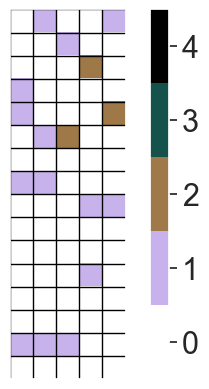

In [88]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = matplotlib.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_colors_bar(discriminator,
                    ratio_gain_results: pd.DataFrame,
                    cells_type: dict):
    colors_data = None
    count = 0
    for idx, row in ratio_gain_results.iterrows():
        colors_vec_hash = row['hash']
        colors_vec = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.colors_vec_hash == colors_vec_hash].iloc[0].colors_vec
        count += len(colors_vec)
        if colors_data is None:
            colors_data = np.array(colors_vec)
        else:
            colors_data = np.append(colors_data, colors_vec)

    colors_data = colors_data.reshape(ratio_gain_results.shape[0], len(cells_type))
    colors_data = colors_data.transpose()
    print(colors_data.shape)
    number_of_colors = 5
    plt.grid(visible=True, color='black', linestyle='-', linewidth=1)
    plt.imshow(colors_data, cmap=discrete_cmap(number_of_colors, 'cubehelix_r'), vmin=0, vmax=number_of_colors)
    plt.colorbar(ticks=range(number_of_colors))
    plt.clim(-0.5, number_of_colors - 0.5)
    plt.xticks(np.arange(-.5, ratio_gain_results.shape[0]-1, 1), labels=[])
    plt.yticks(ticks=np.arange(-.5, len(cells_type)-1, 1), labels=[])
    plt.show()

plot_colors_bar(discriminator_4_nodes, ratio_gain_results, cells_type)

## 3 Nodes
## Within-motif spatial organization contributes to disease state prediction

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


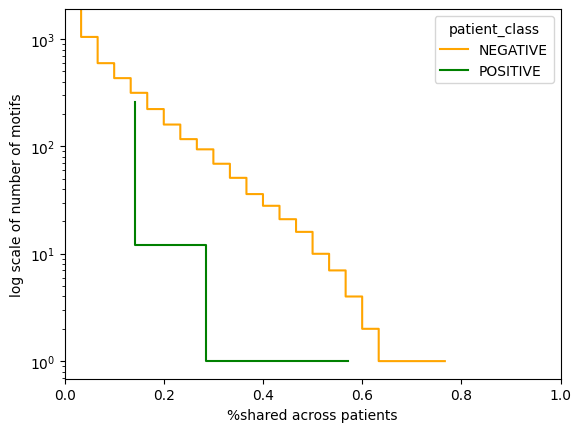

In [16]:
discover_result = discriminator_3_nodes.discover(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES, classes=['NEGATIVE', 'POSITIVE'])

discover_result.plot_number_of_motifs_versus_shared_percentage(class_to_color=class_to_color)

In [14]:
shared_percentage_th = 0.45

In [18]:
from cism.cism import DiscriminativeFeatureKey, HardDiscriminativeFC

featureConf = HardDiscriminativeFC(extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
                                   use_cells_type_composition=False,
                                   use_motifs=True,
                                   shared_percentage=shared_percentage_th,
                                   max_class_features=30,
                                   labels=['POSITIVE', 'NEGATIVE'])

motif_space_features = discriminator_3_nodes.get_features(feature_conf=featureConf,
                                                  exclude_patients=[],
                                                  n_jobs=1)

  0%|          | 0/37 [00:00<?, ?it/s]

FixedFormatter should only be used together with FixedLocator


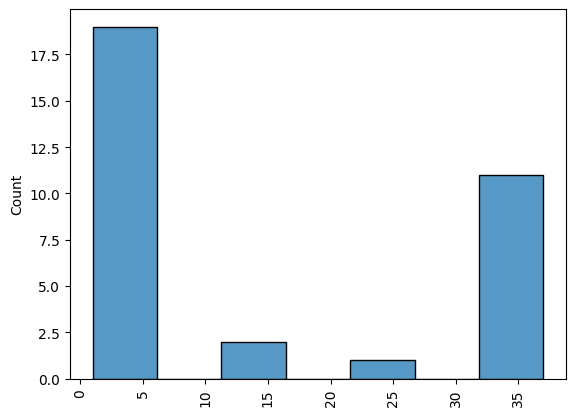

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

counter_across_patients = Counter()
for idx, row in motif_space_features.iterrows():
    counter_across_patients.update(row['features'])

g = sns.histplot(counter_across_patients)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

In [21]:
optimal_result = discriminator_3_nodes.analyze_motifs(feature_conf=featureConf,
                                                      exclude_patients=[],
                                                      n_jobs=1)
optimal_result.get_roc_auc_score()

  0%|          | 0/37 [00:00<?, ?it/s]

0.8476190476190476

In [20]:
all_motif_features = []
for idx, row in motif_space_features.iterrows():
    all_motif_features += row['features']
all_motif_features = list(set(all_motif_features))

motif_to_cells_identity_hash = {}
for motif_id in all_motif_features:
    motif_to_cells_identity_hash[motif_id] = discriminator_3_nodes.cism.motifs_dataset[discriminator_3_nodes.cism.motifs_dataset.ID == motif_id].colors_vec_hash.iloc[0]

cell_identity_to_motif_hash = {}
for k, v in motif_to_cells_identity_hash.items():
    cell_identity_to_motif_hash[v] = cell_identity_to_motif_hash.get(v, []) + [k]

print(f"number of motifs: {len(motif_to_cells_identity_hash)}, "
      f"number of hashes: {len(cell_identity_to_motif_hash)}")

motif_to_cells_identity_hash

number of motifs: 33, number of hashes: 30


{3454124: 8938787699188410565,
 3964140: 4850565862245278349,
 12385516: -5166752284939523464,
 6072588: -4826981390596129394,
 8202636: -395158436373686009,
 3955884: 6212072527860847364,
 6053036: -8854845265688850345,
 6053164: 5203983912965418814,
 6110508: 781045198055153758,
 6061228: 6512495239480086935,
 11058348: -3622911041628419534,
 4750508: 6512495239480086935,
 6061356: -5592926003202999446,
 6077612: 391868164882289572,
 12369068: -3622911041628419534,
 1866924: 5566782625218365255,
 12401964: 1839184594750841426,
 1867212: 3846638627528876859,
 6077900: 6794497112851034106,
 18726348: 7044852548982914915,
 6052940: 1592853070812828195,
 1899980: -7904838511589044209,
 3947980: 2384766923162765971,
 1866860: 3580840254939402609,
 5567724: -8232997633730303071,
 6052972: 6296317540562037293,
 3955948: 1953587682041931478,
 6094060: -8232997633730303071,
 1858668: -2723953054276735933,
 6061292: -7193036188506692760,
 3955820: 4620830178405356214,
 16574956: 29821754313880

In [21]:
group_a_motifs = []
group_b_motifs = []

relevant_patients = discriminator_3_nodes.get_patients_class(['NEGATIVE', 'POSITIVE'])
for motif_id in all_motif_features:
    patients_ids = discriminator_3_nodes.cism.motifs_dataset[
        (discriminator_3_nodes.cism.motifs_dataset.ID == motif_id) &
        (discriminator_3_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))]['Patient_uId'].unique()
    groups_ids = map(lambda x: relevant_patients.loc[x]['patient_class'], patients_ids)
    counter = Counter(groups_ids)
    if max(counter, key=counter.get) == 'NEGATIVE':
        group_a_motifs.append(motif_id)
    else:
        group_b_motifs.append(motif_id)

In [23]:
discriminator_3_nodes.cism.motifs_dataset['Total'] = discriminator_3_nodes.cism.motifs_dataset['Count']/discriminator_3_nodes.cism.motifs_dataset['Freq']

new_freq_table = discriminator_3_nodes.cism.motifs_dataset[
        (discriminator_3_nodes.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator_3_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID'], observed=True)[['Count', 'Total']].sum().reset_index()

new_freq_table['Freq'] = new_freq_table['Count']/new_freq_table['Total']
motif_mean_count = new_freq_table.groupby('ID')['Freq'].mean()

In [24]:
from cism import helpers
import networkx as nx
import numpy as np

def create_weight_matrix_from_motifs(discriminator,
                                     cells_type: dict,
                                     cell_identity_to_motif_hash: dict,
                                     motifs_ids: list,
                                     motifs_weight: pd.DataFrame) -> pd.DataFrame:
    pairwise_cell_types_count_matrix = pd.DataFrame(index=cells_type.values(),
                                                    columns=cells_type.values(),
                                                    dtype=float).fillna(0)

    for hash_id in list(cell_identity_to_motif_hash.keys()):
        motifs = cell_identity_to_motif_hash[hash_id]
        for motif_id in motifs:
            if motif_id not in motifs_ids:
                continue
            print(f'motif_id: {motif_id}, hash_id: {hash_id}')
            target_motif = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.ID == motif_id].iloc[0].motif
            from cism.helpers import string_base64_pickle
            target_motif = string_base64_pickle(target_motif)
            for edge in nx.Graph(target_motif).edges():
                left_node = target_motif.nodes[edge[0]]['type']
                right_node = target_motif.nodes[edge[1]]['type']
                pairwise_cell_types_count_matrix.loc[cells_type[int(left_node)], cells_type[int(right_node)]] += motifs_weight.loc[motif_id]

    return pairwise_cell_types_count_matrix/np.matrix(pairwise_cell_types_count_matrix).sum()

In [25]:
print(f'Negative - {len(group_a_motifs)}')
print(f'Positive - {len(group_b_motifs)}')

Negative - 32
Positive - 1


motif_id: 3454124, hash_id: 8938787699188410565
motif_id: 3964140, hash_id: 4850565862245278349
motif_id: 12385516, hash_id: -5166752284939523464
motif_id: 6072588, hash_id: -4826981390596129394
motif_id: 3955884, hash_id: 6212072527860847364
motif_id: 6053036, hash_id: -8854845265688850345
motif_id: 6053164, hash_id: 5203983912965418814
motif_id: 6110508, hash_id: 781045198055153758
motif_id: 6061228, hash_id: 6512495239480086935
motif_id: 4750508, hash_id: 6512495239480086935
motif_id: 11058348, hash_id: -3622911041628419534
motif_id: 12369068, hash_id: -3622911041628419534
motif_id: 6061356, hash_id: -5592926003202999446
motif_id: 6077612, hash_id: 391868164882289572
motif_id: 1866924, hash_id: 5566782625218365255
motif_id: 12401964, hash_id: 1839184594750841426
motif_id: 1867212, hash_id: 3846638627528876859
motif_id: 6077900, hash_id: 6794497112851034106
motif_id: 18726348, hash_id: 7044852548982914915
motif_id: 6052940, hash_id: 1592853070812828195
motif_id: 1899980, hash_id: -79

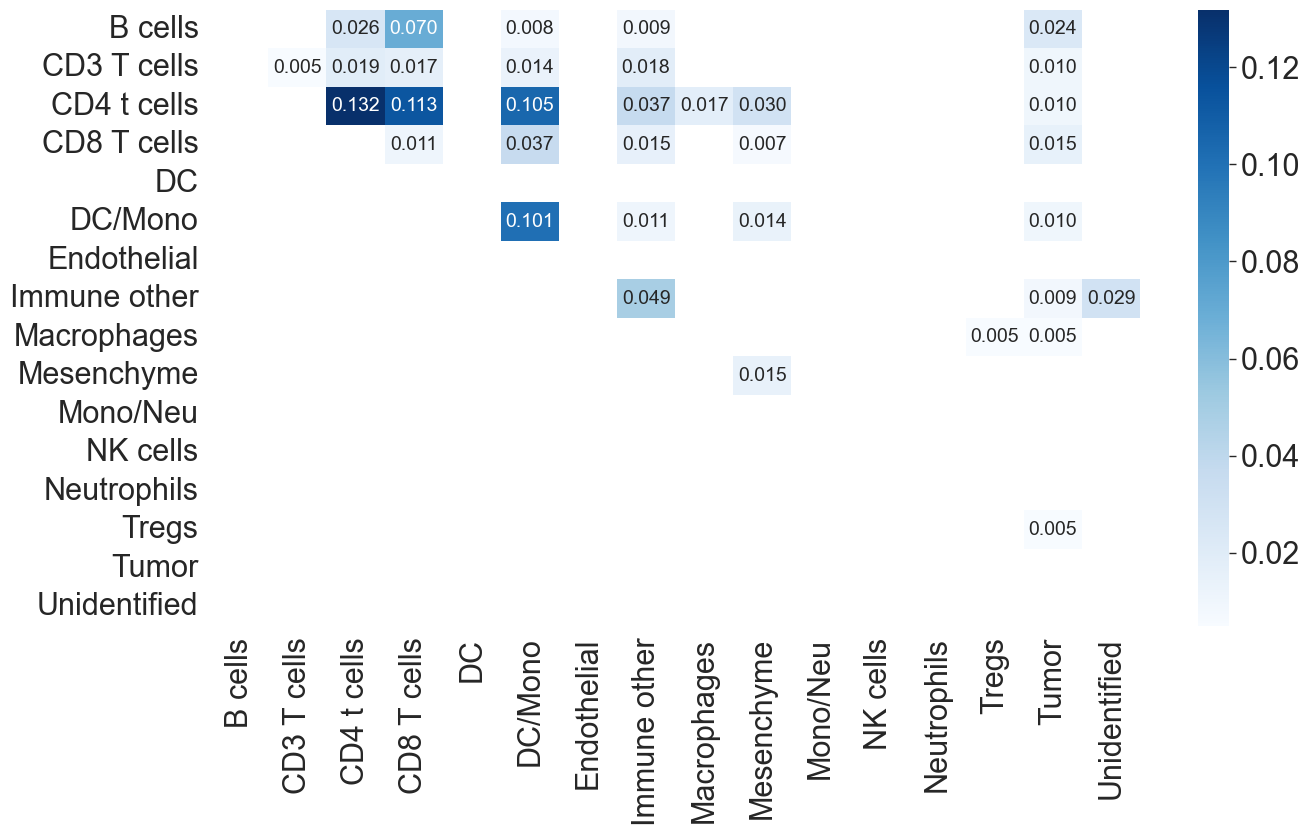

In [27]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df = create_weight_matrix_from_motifs(discriminator=discriminator_3_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_a_motifs,
                                      motifs_weight=motif_mean_count)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Blues', annot_kws={'size': 14}, fmt=".3f")

motif_id: 8202636, hash_id: -395158436373686009


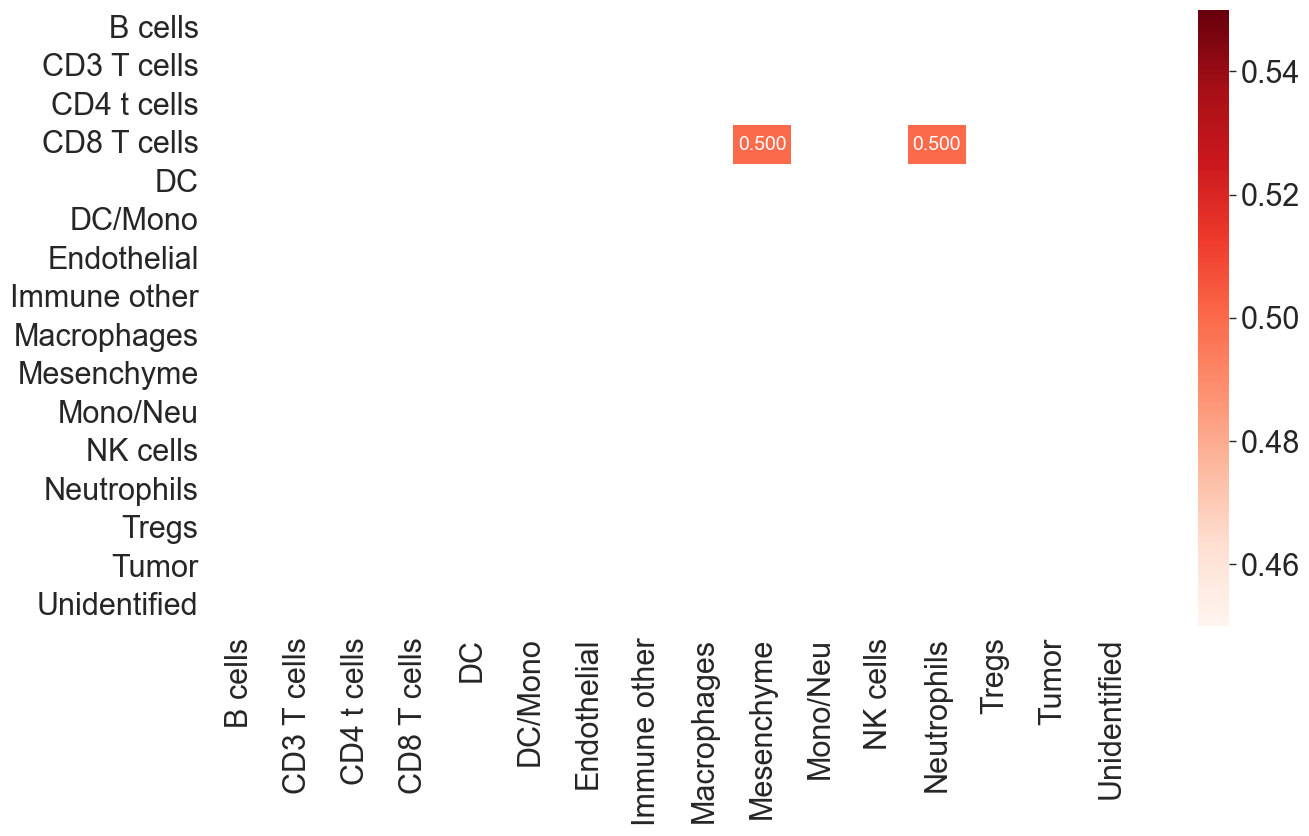

In [28]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))

sns.set(font_scale=2)
sns.set_style("white")
sns.set_context("paper", font_scale=2.5)

df = create_weight_matrix_from_motifs(discriminator=discriminator_3_nodes,
                                      cells_type=cells_type,
                                      cell_identity_to_motif_hash=cell_identity_to_motif_hash,
                                      motifs_ids=group_b_motifs,
                                      motifs_weight=motif_mean_count)

ax = sns.heatmap(df, annot=True, mask=df==0, cmap='Reds', annot_kws={'size': 14}, fmt=".3f")

In [49]:
from typing import Union

def switch_ci(motif_space_features: pd.DataFrame,
              target_motif_ids: list,
              motif_to_cells_identity_hash: dict) -> (dict, dict):
    motifs_features_dict = dict()
    ci_features_dict = dict()

    for idx, row in motif_space_features.iterrows():
        patient_unique_id = row['test_patient_id']
        motif_ids = row['features']
        # transform to cell identity composition
        ci_features = []
        motifs_features = []
        for motif_id in motif_ids:
            if motif_id in target_motif_ids:
                motifs_features.append(motif_id)
                continue

            ci_features.append(motif_to_cells_identity_hash[motif_id])

        ci_features = list(set(ci_features))
        motifs_features_dict[patient_unique_id] = motifs_features
        ci_features_dict[patient_unique_id] = ci_features

    return motifs_features_dict, ci_features_dict

import numpy as np

switch_all_roc_auc_scores = []
for trial in range(1):
    motifs_patient_map, cell_type_composition_patient_map = \
        switch_ci(motif_space_features=motif_space_features,
                  target_motif_ids=[],
                  motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    featureConf = HardDiscriminativeFC(
        extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
        use_cells_type_composition=False,
        use_motifs=True,
        shared_percentage=shared_percentage_th,
        max_class_features=10,
        labels=['NEGATIVE', 'POSITIVE'],
        cell_type_composition_patient_map=cell_type_composition_patient_map,
        motifs_patient_map=motifs_patient_map)

    switch_all_result = discriminator_3_nodes.analyze_motifs(feature_conf=featureConf,
                                                     exclude_patients=[],
                                                     n_jobs=1,
                                                     random_state=np.random.RandomState(trial))

    switch_all_roc_auc_scores.append(switch_all_result.get_roc_auc_score())
    print(switch_all_result.get_roc_auc_score())

np.mean(switch_all_roc_auc_scores)

  0%|          | 0/37 [00:00<?, ?it/s]

0.7666666666666667


0.7666666666666667

In [50]:
import numpy as np
ratio_gain_results = pd.DataFrame(columns=['hash'])

for motif_id in all_motif_features:
    hash = motif_to_cells_identity_hash[motif_id]
    # get the hash group
    motif_ids = cell_identity_to_motif_hash[hash]

    if any(ratio_gain_results.hash.isin([hash])):
        continue

    motifs_patient_map, cell_type_composition_patient_map = \
            switch_ci(motif_space_features=motif_space_features,
                      target_motif_ids=motif_ids,
                      motif_to_cells_identity_hash=motif_to_cells_identity_hash)

    roc_auc_scores = []
    for trial in [0]:
        featureConf = HardDiscriminativeFC(
            extract_by=DiscriminativeFeatureKey.STRUCTURE_AND_CELL_IDENTITIES,
            use_cells_type_composition=False,
            use_motifs=True,
            shared_percentage=shared_percentage_th,
            max_class_features=10,
            labels=['NEGATIVE', 'POSITIVE'],
            cell_type_composition_patient_map=cell_type_composition_patient_map,
            motifs_patient_map=motifs_patient_map)

        analyze_motifs_result = discriminator_3_nodes.analyze_motifs(feature_conf=featureConf,
                                                             exclude_patients=[],
                                                             n_jobs=1,
                                                             random_state=0)

        roc_auc_score = analyze_motifs_result.get_roc_auc_score()
        roc_auc_scores.append(roc_auc_score)

    print(f'hash: {hash}, '
          f'roc_auc_score: {np.mean(roc_auc_scores)}, '
          f'roc_auc_ratio: {optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores)}, '
          f"avg features: {analyze_motifs_result.results['cFeatures'].mean()}, "
          f"std features: {analyze_motifs_result.results['cFeatures'].std()}, "
          f"number of mapped features: {len(motif_ids)}")

    ratio_gain_results = pd.concat([ratio_gain_results,
                                    pd.DataFrame([{'hash': hash,
                                                   'roc_auc_score': np.mean(roc_auc_scores),
                                                   'roc_auc_score_std': np.std(roc_auc_scores),
                                                   'roc_auc_scores': roc_auc_scores,
                                                   'roc_auc_ratio': optimal_result.get_roc_auc_score()/np.mean(roc_auc_scores),
                                                   'avg_features': analyze_motifs_result.results['cFeatures'].mean(),
                                                   'std_features': analyze_motifs_result.results['cFeatures'].std(),
                                                   'mapped_features': len(motif_ids),
                                                   'analyze_result': analyze_motifs_result}])], ignore_index=True)
ratio_gain_results

  0%|          | 0/37 [00:00<?, ?it/s]

hash: -2723953054276735933, roc_auc_score: 0.7428571428571429, roc_auc_ratio: 1.1923076923076923, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: -5592926003202999446, roc_auc_score: 0.7476190476190476, roc_auc_ratio: 1.1847133757961783, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: 6512495239480086935, roc_auc_score: 0.7761904761904762, roc_auc_ratio: 1.1411042944785275, avg features: 6.162162162162162, std features: 0.6015495506289252, number of mapped features: 2


  0%|          | 0/37 [00:00<?, ?it/s]

hash: -3622911041628419534, roc_auc_score: 0.780952380952381, roc_auc_ratio: 1.1341463414634145, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: 6794497112851034106, roc_auc_score: 0.8333333333333334, roc_auc_ratio: 1.0628571428571427, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: 6296317540562037293, roc_auc_score: 0.6904761904761905, roc_auc_ratio: 1.282758620689655, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: -395158436373686009, roc_auc_score: 0.8095238095238095, roc_auc_ratio: 1.0941176470588234, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: 3846638627528876859, roc_auc_score: 0.7333333333333334, roc_auc_ratio: 1.2077922077922076, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: -8232997633730303071, roc_auc_score: 0.7428571428571429, roc_auc_ratio: 1.1923076923076923, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: -8854845265688850345, roc_auc_score: 0.7476190476190476, roc_auc_ratio: 1.1847133757961783, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: -4826981390596129394, roc_auc_score: 0.7238095238095238, roc_auc_ratio: 1.2236842105263157, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: 298217543138803088, roc_auc_score: 0.7380952380952381, roc_auc_ratio: 1.2, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


  0%|          | 0/37 [00:00<?, ?it/s]

hash: 1592853070812828195, roc_auc_score: 0.7000000000000001, roc_auc_ratio: 1.2653061224489794, avg features: 5.216216216216216, std features: 0.5838157593289521, number of mapped features: 1


,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
0,-2723953054276735933,0.742857,0.0,[0.7428571428571429],1.192308,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,-5592926003202999446,0.747619,0.0,[0.7476190476190476],1.184713,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,6512495239480086935,0.776190,0.0,[0.7761904761904762],1.141104,6.162162,0.601550,2.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,-3622911041628419534,0.780952,0.0,[0.780952380952381],1.134146,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
4,6794497112851034106,0.833333,0.0,[0.8333333333333334],1.062857,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
5,6296317540562037293,0.690476,0.0,[0.6904761904761905],1.282759,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
6,-395158436373686009,0.809524,0.0,[0.8095238095238095],1.094118,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
7,3846638627528876859,0.733333,0.0,[0.7333333333333334],1.207792,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
8,-8232997633730303071,0.742857,0.0,[0.7428571428571429],1.192308,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
9,-8854845265688850345,0.747619,0.0,[0.7476190476190476],1.184713,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


In [51]:
ratio_gain_results = ratio_gain_results.sort_values(by='roc_auc_score', ascending=False)
ratio_gain_results

,hash,roc_auc_score,roc_auc_score_std,roc_auc_scores,roc_auc_ratio,avg_features,std_features,mapped_features,analyze_result
4,6794497112851034106,0.833333,0.0,[0.8333333333333334],1.062857,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
6,-395158436373686009,0.809524,0.0,[0.8095238095238095],1.094118,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
3,-3622911041628419534,0.780952,0.0,[0.780952380952381],1.134146,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
2,6512495239480086935,0.776190,0.0,[0.7761904761904762],1.141104,6.162162,0.601550,2.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
1,-5592926003202999446,0.747619,0.0,[0.7476190476190476],1.184713,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
9,-8854845265688850345,0.747619,0.0,[0.7476190476190476],1.184713,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
0,-2723953054276735933,0.742857,0.0,[0.7428571428571429],1.192308,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
8,-8232997633730303071,0.742857,0.0,[0.7428571428571429],1.192308,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
11,298217543138803088,0.738095,0.0,[0.7380952380952381],1.200000,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...
7,3846638627528876859,0.733333,0.0,[0.7333333333333334],1.207792,5.216216,0.583816,1.0,<cism.cism.AnalyzeMotifsResult object at 0x000...


(16, 13)


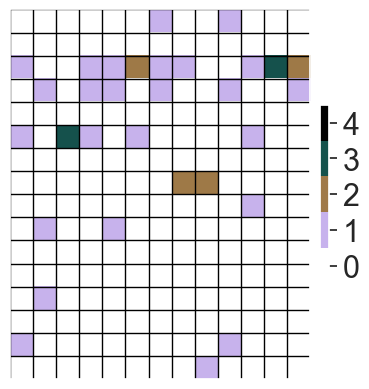

In [53]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = matplotlib.colormaps.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def plot_colors_bar(discriminator,
                    ratio_gain_results: pd.DataFrame,
                    cells_type: dict):
    colors_data = None
    count = 0
    for idx, row in ratio_gain_results.iterrows():
        colors_vec_hash = row['hash']
        colors_vec = discriminator.cism.motifs_dataset[discriminator.cism.motifs_dataset.colors_vec_hash == colors_vec_hash].iloc[0].colors_vec
        count += len(colors_vec)
        if colors_data is None:
            colors_data = np.array(colors_vec)
        else:
            colors_data = np.append(colors_data, colors_vec)

    colors_data = colors_data.reshape(ratio_gain_results.shape[0], len(cells_type))
    colors_data = colors_data.transpose()
    print(colors_data.shape)
    number_of_colors = 5
    plt.grid(visible=True, color='black', linestyle='-', linewidth=1)
    plt.imshow(colors_data, cmap=discrete_cmap(number_of_colors, 'cubehelix_r'), vmin=0, vmax=number_of_colors)
    plt.colorbar(ticks=range(number_of_colors), fraction=0.018, pad=0.02)
    plt.clim(-0.5, number_of_colors - 0.5)
    plt.xticks(np.arange(-.5, ratio_gain_results.shape[0]-1, 1), labels=[])
    plt.yticks(ticks=np.arange(-.5, len(cells_type)-1, 1), labels=[])
    plt.show()

plot_colors_bar(discriminator_3_nodes, ratio_gain_results, cells_type)

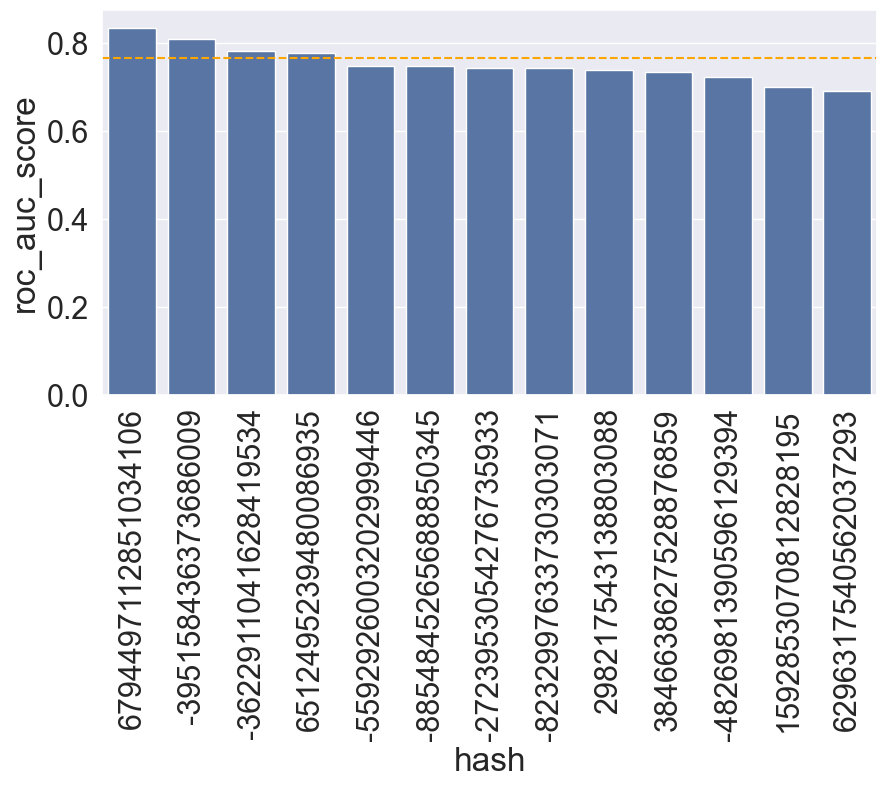

In [54]:
import seaborn as sns
plt.figure(figsize=(10,5))
g = sns.barplot(ratio_gain_results, x='hash', y='roc_auc_score', order=ratio_gain_results['hash'])
plt.xticks(rotation=90)
g.axhline(np.mean(switch_all_roc_auc_scores), ls='--', color='orange', ms='50')

In [55]:
ratio_gain_results.to_csv(results_dir +'/' + f'ratio_gain_{local_motif_size}_results.csv' )

In [31]:
discriminator_3_nodes.cism.motifs_dataset[
        (discriminator_3_nodes.cism.motifs_dataset.ID.isin(all_motif_features)) &
        (discriminator_3_nodes.cism.motifs_dataset['Patient_uId'].isin(relevant_patients.index))].groupby(['Patient', 'ID', 'colors_vec_hash'], observed=True)['Count'].sum().reset_index().to_csv(results_dir +'/' + f'{local_motif_size}_motifs_counts_across_patients.csv')

motif_id: 6077900, hash_id: 6794497112851034106


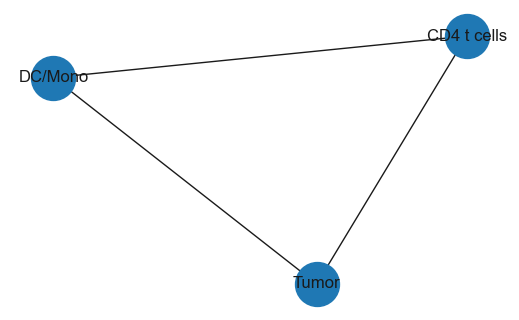

motif_id: 8202636, hash_id: -395158436373686009


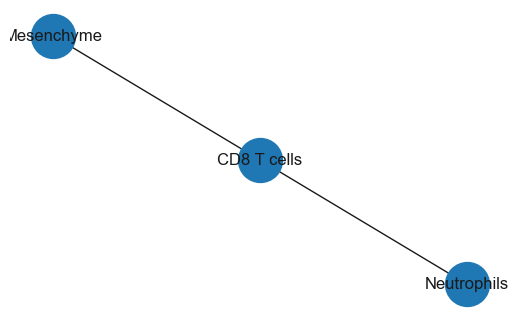

motif_id: 11058348, hash_id: -3622911041628419534


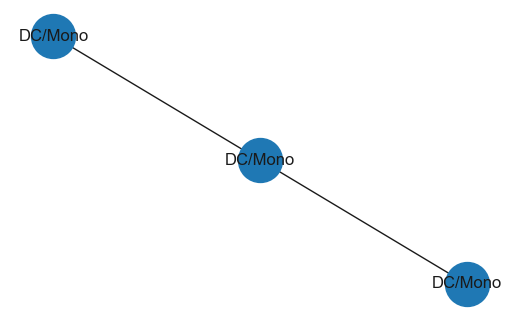

motif_id: 6061228, hash_id: 6512495239480086935


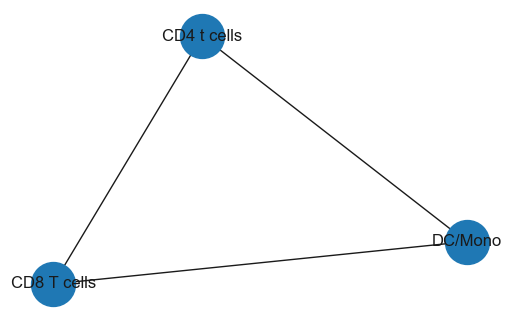

motif_id: 4750508, hash_id: 6512495239480086935


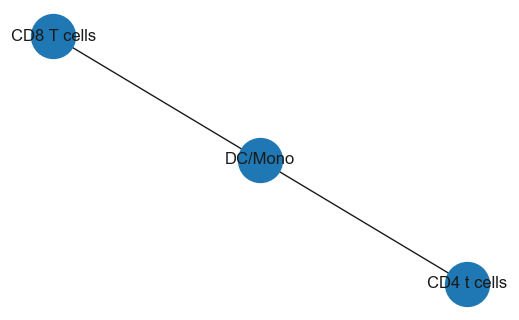

motif_id: 6061356, hash_id: -5592926003202999446


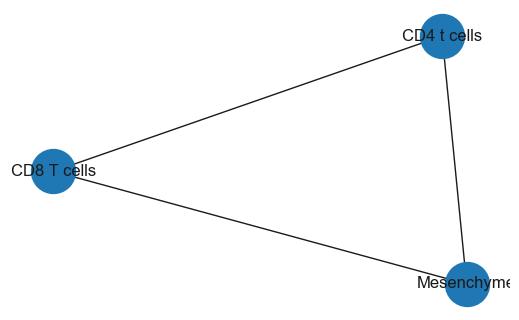

motif_id: 6053036, hash_id: -8854845265688850345


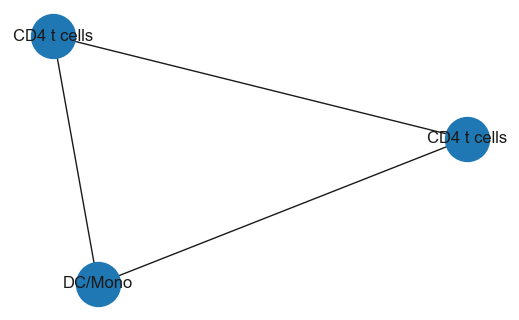

motif_id: 1858668, hash_id: -2723953054276735933


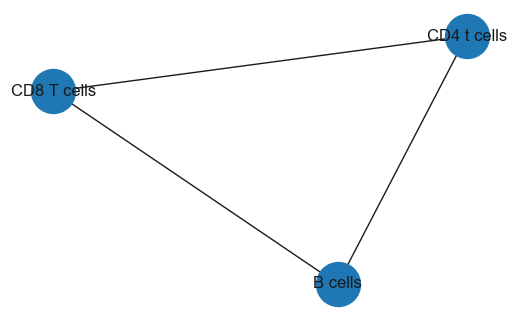

motif_id: 5567724, hash_id: -8232997633730303071


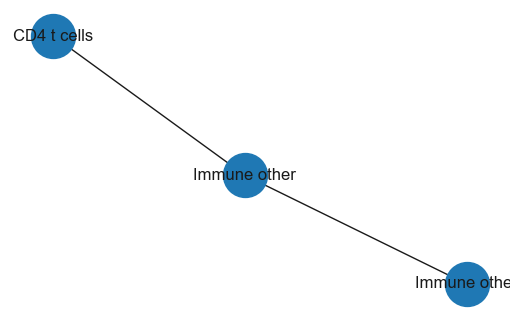

motif_id: 16574956, hash_id: 298217543138803088


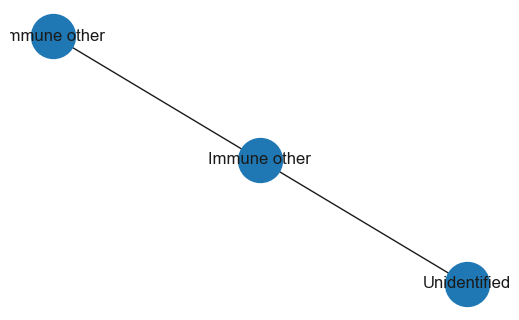

motif_id: 1867212, hash_id: 3846638627528876859


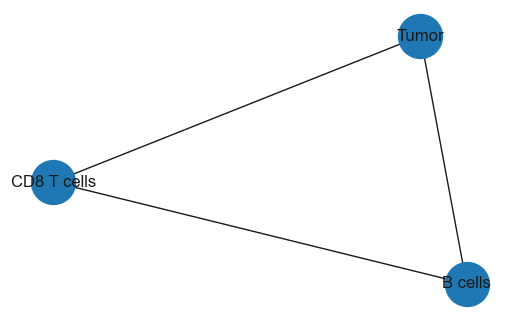

motif_id: 6072588, hash_id: -4826981390596129394


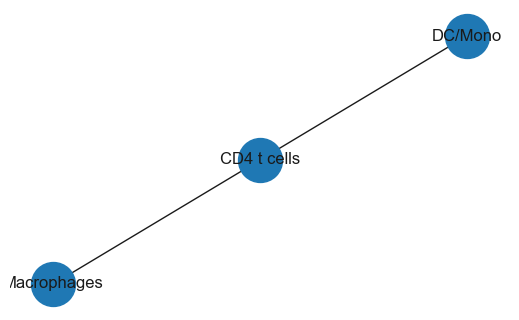

motif_id: 6052940, hash_id: 1592853070812828195


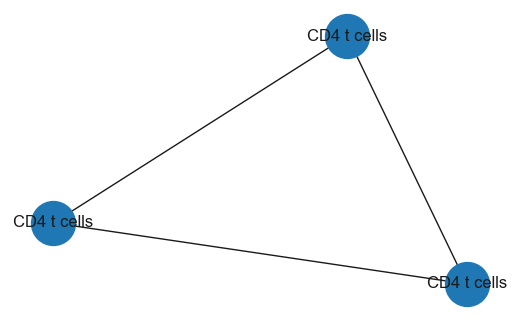

motif_id: 6052972, hash_id: 6296317540562037293


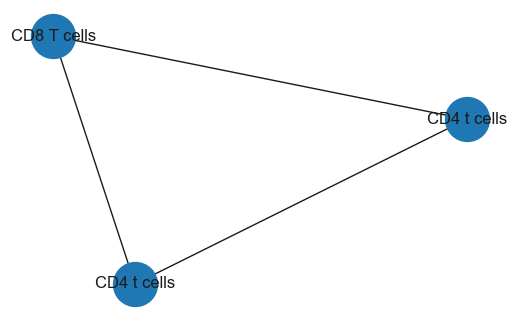

In [57]:
from cism.vis import draw

for idx, row in ratio_gain_results.iterrows():
    hash_id = ratio_gain_results.loc[idx].hash
    motifs = cell_identity_to_motif_hash[ratio_gain_results.loc[idx].hash]
    for motif_id in motifs:
        print(f'motif_id: {motif_id}, hash_id: {hash_id}')
        target_motif = cism_3_nodes.motifs_dataset[cism_3_nodes.motifs_dataset.ID == motif_id].iloc[0].motif
        target_motif = helpers.string_base64_pickle(target_motif)
        draw.draw_motif(target_motif, cells_type=cells_type)